# El Nino-like warming pattern in LongRunMIP
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [11]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.patches import Polygon
from scipy import signal
from scipy import stats
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from shapely import geometry

Model names

In [12]:
modelnames_fig = ['CCSM3 abrupt 4x','CESM1.0.4 abrupt 4x','CNRM-CM6.1 abrupt 4x', \
    'GFDL-CM3 1pct 2x','GFDL-ESM2M 1pct 2x','GISS-E2-R abrupt 4x','HadCM3L abrupt 4x', \
    'IPSL-CM5A-LR abrupt 4x','MIROC3.2 1pct 4x','MPIESM-1.2 abrupt 4x']

modelnames_file = ['CCSM3_abrupt4x','CESM104_abrupt4x','CNRMCM61_abrupt4x', \
    'GFDLCM3_1pct2x','GFDLESM2M_1pct2x','GISSE2R_abrupt4x','HadCM3L_abrupt4x', \
    'IPSLCM5A_abrupt4x','MIROC32_1pct4x','MPIESM12_abrupt4x']

runtype = ['abrupt','abrupt','abrupt','lin','lin', \
            'abrupt','abrupt','abrupt','abrupt','abrupt'] 

Data location

In [13]:
loc_tas = "~/" # change if using raw data
loc_spatial_warming = "../Data/Spatial_Warming/"

Detrend

In [14]:
def custom_detrend(data,order):
    
    # only for one-dimensional timeseries
    # numpy required
    
    x = np.arange(1,len(data)+1,1)
    
    model = np.polyfit(x,data,order)
    predicted = np.polyval(model,x)
    new = data - predicted
    
    return(new)

List files

In [15]:
def list_files(directory, extension):
    
    # Credit to: http://www.martinbroadhurst.com/listing-all-files-in-a-directory-with-a-certain-extension-in-python.html
    # Requires os.listdir
    
    return (f for f in os.listdir(directory) if f.endswith(extension))

Tropical pacific

In [17]:
lat_min = -15
lat_max = 15
lon_min = 150
lon_max = 280

#### Analysis

In [20]:
calculate = False # not using raw data here

In [21]:
if calculate:
    for i in np.arange(0,len(modelnames_file),1):

        model, exp = modelnames_file[i].split("_")
        print(modelnames_file[i])
        
        fname_exp_start = "tas_mon_"+modelnames_file[i]
        fname_control_start = "tas_mon_"+model+"_control"

        fname_exp = [f for f in os.listdir(loc_tas) if f.startswith(fname_exp_start)][0]
        fname_control = [f for f in os.listdir(loc_tas) if f.startswith(fname_control_start)][0]

        n1, n2, n3, n4, year_exp_nc = fname_exp.split("_")
        n1, n2, n3, n4, year_control_nc = fname_control.split("_")
        year_exp, nc = year_exp_nc.split(".")
        year_control, nc = year_control_nc.split(".")

        model_decode_times_list = ["MIROC32","MPIESM12"]

        if model in model_decode_times_list:
            tas_exp_global = xr.DataArray(xr.open_dataset(loc_tas+fname_exp,decode_times=False).data_vars["tas"]) 
            tas_control_global = xr.DataArray(xr.open_dataset(loc_tas+fname_control,decode_times=False).data_vars["tas"])
        else:
            tas_exp_global = xr.DataArray(xr.open_dataset(loc_tas+fname_exp).data_vars["tas"])
            tas_control_global = xr.DataArray(xr.open_dataset(loc_tas+fname_control).data_vars["tas"])

        if model == "HadCM3L":
            lat_tas = tas_exp_global.coords["latitude_1"]
            lon_tas = tas_exp_global.coords["longitude_1"]
            latname = "latitude_1"
            lonname = "longitude_1"
        else:
            lat_tas = tas_exp_global.coords["lat"]
            lon_tas = tas_exp_global.coords["lon"]
            latname = "lat"
            lonname = "lon"

        if lat_tas[0] > lat_tas[len(lat_tas.values)-1]:
            latmax = lat_min
            latmin = lat_max
        else:
            latmin = lat_min
            latmax = lat_max

        if exp.startswith("abrupt"):
            eq_period = 150
        else:
            eq_period = 140

        tas_exp_pacific = tas_exp_global[(eq_period*12):,:,:].loc[:,latmin:latmax,lon_min:lon_max]
        lat_pacific = tas_exp_pacific.coords[latname]
        lon_pacific = tas_exp_pacific.coords[lonname]
        time_exp = tas_exp_pacific.coords["time"]
        tas_control_pacific = tas_control_global.loc[:,latmin:latmax,lon_min:lon_max]
        time_control = tas_control_pacific.coords["time"]

        tas_exp_pacific_dt = xr.DataArray(np.full((tas_exp_pacific.values.shape),np.nan),
                                          coords=[time_exp,lat_pacific,lon_pacific],
                                          dims=["time","lat","lon"])
        tas_control_pacific_dt = xr.DataArray(np.full((tas_control_pacific.values.shape),np.nan),
                                          coords=[time_control,lat_pacific,lon_pacific],
                                          dims=["time","lat","lon"])
        #for j in np.arange(0,len(lat_pacific),1):
        #    for k in np.arange(0,len(lon_pacific),1):
        #        tas_exp_pacific_dt[:,j,k] = custom_detrend(tas_exp_pacific[:,j,k].values,ordr)
        #        tas_control_pacific_dt[:,j,k] = custom_detrend(tas_control_pacific[:,j,k].values,ordr)

        tas_exp_pacific_dt[:,:,:] = tas_exp_pacific.values
        tas_control_pacific_dt[:,:,:] = tas_control_pacific.values

        warming_pattern = tas_exp_pacific_dt.mean(dim="time") - tas_control_pacific_dt.mean(dim="time")

        #print(warming_pattern)

        # write out 
        warming_pattern.name = "pattern"
        warming_pattern.attrs["creation_date"] = str(datetime.datetime.now())
        warming_pattern.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
        warming_pattern.attrs["data_description"] = "Pacific temperature warming pattern"
        warming_pattern.attrs["created_from"] = "FigX_Warming_Pattern.ipynb"

        fname_out = loc_spatial_warming+"warming_pattern_"+model+"_"+exp+".nc"
        warming_pattern.to_netcdf(fname_out,mode="w")
        print(fname_out)

CCSM3_abrupt4x
../Data/Spatial_Warming/warming_pattern_CCSM3_abrupt4x.nc
CESM104_abrupt4x
../Data/Spatial_Warming/warming_pattern_CESM104_abrupt4x.nc
CNRMCM61_abrupt4x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, or

../Data/Spatial_Warming/warming_pattern_CNRMCM61_abrupt4x.nc
GFDLCM3_1pct2x


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


../Data/Spatial_Warming/warming_pattern_GFDLCM3_1pct2x.nc
GFDLESM2M_1pct2x
../Data/Spatial_Warming/warming_pattern_GFDLESM2M_1pct2x.nc
GISSE2R_abrupt4x
../Data/Spatial_Warming/warming_pattern_GISSE2R_abrupt4x.nc
HadCM3L_abrupt4x
../Data/Spatial_Warming/warming_pattern_HadCM3L_abrupt4x.nc
IPSLCM5A_abrupt4x
../Data/Spatial_Warming/warming_pattern_IPSLCM5A_abrupt4x.nc
MIROC32_1pct4x
../Data/Spatial_Warming/warming_pattern_MIROC32_1pct4x.nc
MPIESM12_abrupt4x
../Data/Spatial_Warming/warming_pattern_MPIESM12_abrupt4x.nc


CCSM3_abrupt4x
CESM104_abrupt4x
CNRMCM61_abrupt4x
GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_abrupt4x
HadCM3L_abrupt4x
IPSLCM5A_abrupt4x
MIROC32_1pct4x
MPIESM12_abrupt4x


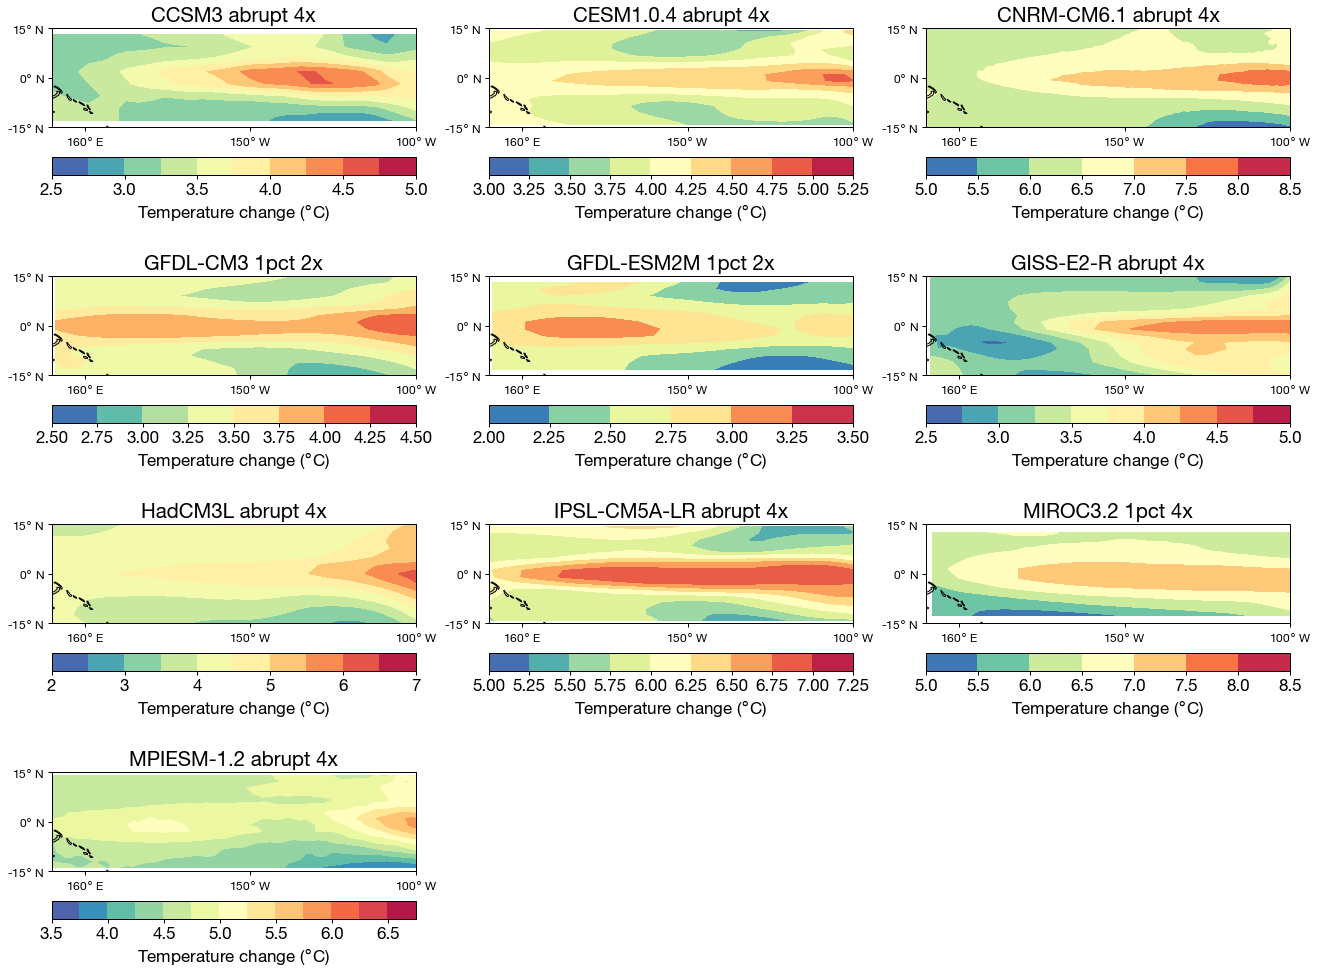

In [23]:
fig = plt.figure(figsize=(20,17))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 17
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1

gs1 = gridspec.GridSpec(4,3)
gs1.update(left=0.1,right=0.96,top=0.93,bottom=0.16,wspace=0.2,hspace=0.25)

for i in np.arange(0,len(modelnames_file),1):
    
    model, exp = modelnames_file[i].split("_")
    print(modelnames_file[i])
    
    warming_pattern = xr.open_dataarray(loc_spatial_warming+"warming_pattern_"+model+"_"+exp+".nc")
    lat = warming_pattern.coords["lat"]
    lon = warming_pattern.coords["lon"]
    
    ax = plt.subplot(gs1[i],projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-210,-100,lat_min,lat_max],crs=ccrs.PlateCarree())
    ax.coastlines()
    
    lons, lats = np.meshgrid(lon, lat)
    
    if model == "CCSM3":
        clevs = np.arange(2.5,5+0.25,0.25)
    if model == "CESM104":
        clevs = np.arange(3,5.25+0.25,0.25)
    if model == "CNRMCM61":
        clevs = np.arange(5,8.5+0.5,0.5)
    if model == "GFDLCM3":
        clevs = np.arange(2.5,4.5+0.25,0.25)
    if model == "GFDLESM2M":
        clevs = np.arange(2,3.5+0.25,0.25)
    if model == "GISSE2R":
        clevs = np.arange(2.5,5+0.25,0.25)
    if model == "HadCM3L":
        clevs = np.arange(2,7+0.5,0.5)
    if model == "IPSLCM5A":
        clevs = np.arange(5,7.25+0.25,0.25)
    if model == "MIROC32":
        clevs = np.arange(5,8.5+0.5,0.5)
    if model == "MPIESM12":
        clevs = np.arange(3.5,6.75+0.25,0.25)
        
    cs = ax.contourf(lons,lats,warming_pattern.values,clevs,cmap="Spectral_r",transform=ccrs.PlateCarree(),
                    extend="neither")
    plt.title(modelnames_fig[i])
    
    ax.set_xticks([-200,-150,-100], crs=ccrs.PlateCarree())
    ax.set_xticklabels(["160$\degree$ E","150$\degree$ W","100$\degree$ W"],fontsize=12)
    ax.set_yticks([-15,0,15], crs=ccrs.PlateCarree())
    ax.set_yticklabels(["-15$\degree$ N","0$\degree$ N","15$\degree$ N"],fontsize=12)
    
    fig.colorbar(cs,ax=ax,orientation="horizontal",label="Temperature change ($\degree$C)")
    
    
plt.savefig("../Figures/FigS9_Warming_Pattern.pdf")
plt.show()